# Comparing Forecasts on Major League Baseball (MLB) Games

We compare probability forecasts on the outcome of all MLB games from 2010 to 2019, culminating with the [2019 World Series](https://en.wikipedia.org/wiki/2019_World_Series) between Houston Astros and Washington Nationals. 

The 2019 World Series is an interesting test case, as the Nationals defied the odds given by many professional forecasters and baseball experts and won 4-3.
It was also [the only major championship series in the four North American sports where the visiting team won all games](https://www.cbssports.com/mlb/news/nationals-vs-astros-road-team-wins-all-seven-games-of-2019-world-series-to-make-history-and-defy-odds/). 
We compare various forecasters that made forecasts game-by-game and compare their performances.

Since this is a post-hoc analysis, we optimize our bounds to be the tightest at the last time step (corresponding to the final game of the 2019 World Series).


YJ Choe [yjchoe@cmu.edu]

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comparecast as cc

%matplotlib inline

In [2]:
# significance level
ALPHA = 0.05
V_OPT = None  # optimize at the final step

## Data

We use three sets of forecasts on the outcome of MLB games from 2010 to 2019, leading up to the final seven World Series games. 
The three forecasts are:
- FiveThirtyEight's win probability projection using the new method (`fivethirtyeight`);
- Closing odds converted to probabilities (source: [Vegas-Odds.com](Vegas-Odds.com)) (`vegas`);
- Various simple baselines from our synthetic experiments (`random`, `laplace`, `k29`).

We make use of [FiveThirtyEight's MLB records](https://github.com/fivethirtyeight/data/tree/6f5b4898481a71cd85ea3c03bb1613dd4a43275b/mlb-elo) as well as its predictions.
The event of interest is defined as whether the Nationals win each game.  
For forecasting algorithms, we use all Nationals games (regular season & postseason) from 2010 to 2019.

## Retrieve FiveThirtyEight Data + Precompute Baselines

In [3]:
team = "MLB"
start_year, end_year = 2010, 2019
plots_dir = f"./plots/{team.lower()}_{start_year}_{end_year}"
os.makedirs(plots_dir, exist_ok=True)

save_file = "data/mlb_elo_538_with_baselines.csv"
data = cc.data_utils.baseball.preprocess_mlb_baselines(2010, 2019, save_file=save_file)  # all years, all teams
data

processing baselines for each team: 100%|██████████| 30/30 [03:19<00:00,  6.66s/it]


,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,constant_log5_prob1,constant_log5_prob2,laplace_prob1,laplace_prob2,laplace_log5_prob1,laplace_log5_prob2,k29_prob1,k29_prob2,k29_log5_prob1,k29_log5_prob2
28031,2010-04-04,2010,0,NaN,BOS,NYY,1537.262000,1568.875000,0.489046,0.510954,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
28018,2010-04-05,2010,0,NaN,WSN,PHI,1460.859000,1541.211000,0.419607,0.580393,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
28019,2010-04-05,2010,0,NaN,TEX,TOR,1515.833000,1514.391000,0.536549,0.463451,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
28020,2010-04-05,2010,0,NaN,PIT,LAD,1454.399000,1525.860000,0.432120,0.567880,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
28021,2010-04-05,2010,0,NaN,OAK,SEA,1509.222000,1501.778000,0.545128,0.454872,...,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,0.5,0.5,0.475988,0.524012,0.437416,0.562584,0.508571,0.491429,0.527073,0.472927
3382,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,0.5,0.5,0.473813,0.526187,0.431914,0.568086,0.516476,0.483524,0.551632,0.448368
3381,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,0.5,0.5,0.471658,0.528342,0.426493,0.573507,0.507236,0.492764,0.522241,0.477759
3380,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,0.5,0.5,0.530477,0.469523,0.578848,0.421152,0.501092,0.498908,0.503315,0.496685


In [4]:
# home win probability
data["win"] = (data["score1"] >= data["score2"]).astype(int)
data["data"] = data["win"]
data["time"] = data.groupby(["date", "team1", "team2"]).ngroup(ascending=True) + 1
data.sort_values("time", inplace=True)

forecasters = [f + "_prob1" for f in ["rating", "elo", "constant", "laplace", "k29"]]
data = data[["date", "season", "playoff", "team1", "team2", 
             "score1", "score2", "time", "data", "win"] + forecasters].copy()
data.rename(lambda x: {
    "rating_prob1": "fivethirtyeight",
    "elo_prob1": "fivethirtyeight_old",
    "constant_prob1": "constant",
    "laplace_prob1": "laplace",
    "k29_prob1": "k29",
}.get(x, x), axis=1, inplace=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,data,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29
3392,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.503955,0.520325
3391,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.511365,0.530884
3390,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.493778,0.487732
3389,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.513871,0.538824
3388,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.491531,0.480209
3387,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.489304,0.471826
3386,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.508401,0.536715
3385,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.528860,0.500000
3384,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.526425,0.499644
3383,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.475988,0.508571


## Process Vegas Odds & Combine with the FiveThirtyEight Data

Source: https://sports-statistics.com/sports-data/mlb-historical-odds-scores-datasets/

In [5]:
vegas_odds = cc.data_utils.baseball.read_vegas_odds(start_year, end_year, team)
vegas_odds.tail(7)

,date,team1,pitcher1,final1,open1,close1,team2,pitcher2,final2,open2,...,open_prob1,open_prob2,open_log5_prob1,open_log5_prob2,close_iprob1,close_iprob2,close_prob1,close_prob2,close_log5_prob1,close_log5_prob2
24642,2019-10-22,HOU,GCOLE-R,4,-200,-200.0,WAS,MSCHERZER-R,5,179,...,0.650350,0.349650,0.775765,0.224235,0.666667,0.357143,0.651163,0.348837,0.777007,0.222993
24643,2019-10-23,HOU,JVERLANDER-R,3,-175,-172.0,WAS,SSTRASBURG-R,12,157,...,0.620559,0.379441,0.727870,0.272130,0.632353,0.383142,0.622704,0.377296,0.731468,0.268532
24644,2019-10-25,WAS,ASANCHEZ-R,1,110,140.0,HOU,ZGREINKE-R,4,-121,...,0.465165,0.534835,0.430667,0.569333,0.416667,0.600000,0.409836,0.590164,0.325351,0.674649
24645,2019-10-26,WAS,PCORBIN-L,1,-115,-108.0,HOU,JURQUIDY-R,8,105,...,0.523017,0.476983,0.545937,0.454063,0.519231,0.504950,0.506972,0.493028,0.513940,0.486060
24646,2019-10-27,WAS,MSCHERZER-R,1,140,190.0,HOU,GCOLE-R,7,-155,...,0.406699,0.593301,0.319676,0.680324,0.344828,0.677419,0.337323,0.662677,0.205790,0.794210
24647,2019-10-29,HOU,JVERLANDER-R,2,-180,-176.0,WAS,SSTRASBURG-R,7,162,...,0.627461,0.372539,0.739367,0.260633,0.637681,0.380228,0.626462,0.373538,0.737717,0.262283
24648,2019-10-30,HOU,ZGREINKE-R,2,-135,-138.0,WAS,MSCHERZER-R,6,122,...,0.560501,0.439499,0.619256,0.380744,0.579832,0.438596,0.569340,0.430660,0.636063,0.363937


In [6]:
map_teamcodes = {
    v: t for t, vs in cc.data_utils.baseball.TEAM_CODES.items() 
    for v in vs
}
for column in ["team1", "team2"]:
    vegas_odds[column] = vegas_odds[column].apply(lambda x: map_teamcodes[x])

In [7]:
forecasters = [f + "_prob1" for f in ["open", "close"]]
vegas_odds = vegas_odds[["date", "team1", "team2",] + forecasters].copy()
vegas_odds.rename(lambda x: {
    "open_prob1": "vegas_open",
    "close_prob1": "vegas",
}.get(x, x), axis=1, inplace=True)
vegas_odds.tail(14)

,date,team1,team2,vegas_open,vegas
24635,2019-10-13,HOU,NYY,0.600246,0.624596
24636,2019-10-14,WSN,STL,0.544024,0.546330
24638,2019-10-15,WSN,STL,0.593301,0.606061
24637,2019-10-15,NYY,HOU,0.399754,0.401733
24639,2019-10-17,NYY,HOU,0.544024,0.560037
24640,2019-10-18,NYY,HOU,0.431344,0.427046
24641,2019-10-19,HOU,NYY,0.568656,0.529605
24642,2019-10-22,HOU,WSN,0.650350,0.651163
24643,2019-10-23,HOU,WSN,0.620559,0.622704
24644,2019-10-25,WSN,HOU,0.465165,0.409836


In [8]:
data = data.merge(vegas_odds, on=["date", "team1", "team2"], sort=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,data,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29,vegas_open,vegas
25151,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.503955,0.520325,0.600246,0.624596
25152,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.511365,0.530884,0.544024,0.546330
25153,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.493778,0.487732,0.399754,0.401733
25154,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.513871,0.538824,0.593301,0.606061
25155,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.491531,0.480209,0.544024,0.560037
25156,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.489304,0.471826,0.431344,0.427046
25157,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.508401,0.536715,0.568656,0.529605
25158,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.528860,0.500000,0.650350,0.651163
25159,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.526425,0.499644,0.620559,0.622704
25160,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.475988,0.508571,0.465165,0.409836


In [9]:
data.to_csv(f"forecasts/{team.lower()}_{start_year}_{end_year}.csv", index=False)

## Comparing All Forecasters

In [10]:
scoring_rule = "brier"

In [11]:
forecasters = ["fivethirtyeight", "vegas", "laplace", "k29", "constant"]

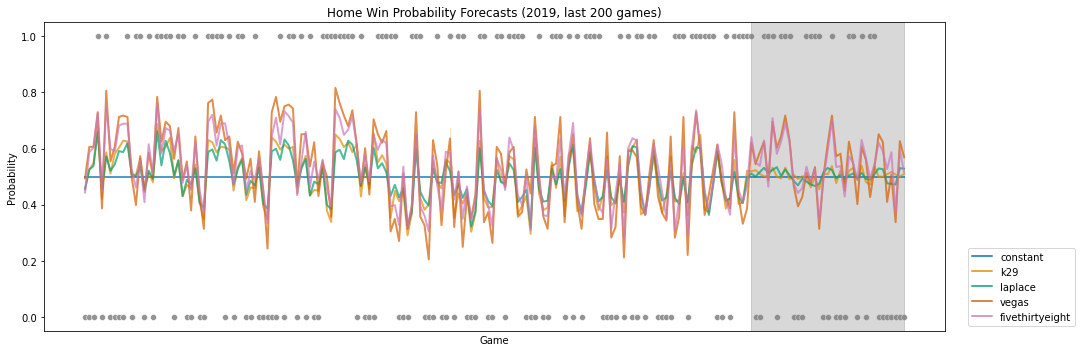

In [12]:
cc.plot_mlb_forecasts(
    data,
    team,
    [2019],
    forecasters[::-1],
    no_playoffs=False,
    window=("2019-10-01", "2019-10-30"),  # playoffs
    n_games=200,
    save_filename=os.path.join(plots_dir, f"forecasts.pdf"),
)

## Main Comparisons

In [13]:
import itertools

scoring_rule = "brier"
for name_p, name_q in itertools.combinations(forecasters, 2):
    lcbs, ucbs = cc.compare_forecasts(
            data,
            name_p,
            name_q,
            scoring_rule=scoring_rule,
            alpha=ALPHA,
            v_opt=V_OPT,
        )
    print(f"{name_p:15} vs. {name_q:15}: ({lcbs[-1]:8.5f}, {ucbs[-1]:8.5f})")

fivethirtyeight vs. vegas          : (-0.00267, -0.00060)
fivethirtyeight vs. laplace        : ( 0.00458,  0.00792)
fivethirtyeight vs. k29            : ( 0.00768,  0.01202)
fivethirtyeight vs. constant       : ( 0.00568,  0.00933)
vegas           vs. laplace        : ( 0.00600,  0.00977)
vegas           vs. k29            : ( 0.00914,  0.01383)
vegas           vs. constant       : ( 0.00717,  0.01110)
laplace         vs. k29            : ( 0.00198,  0.00522)
laplace         vs. constant       : (-0.00043,  0.00294)
k29             vs. constant       : (-0.00456, -0.00013)


## Sample Pair Comparison

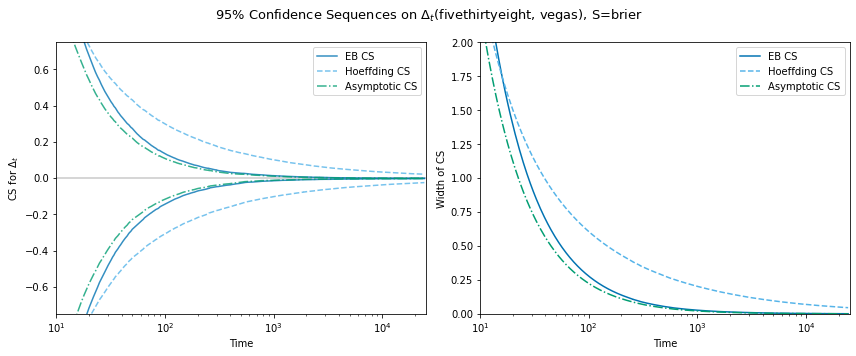

In [14]:
scoring_rule = "brier"
lo, hi = -1, 1
# scoring_rule = "logarithmic"
# lo, hi = np.log(0.01), -np.log(0.01)
ax = cc.plot_comparison(
    data, 
    "fivethirtyeight",
    "vegas",
    scoring_rule=scoring_rule,
    alpha=ALPHA,
    lo=lo,
    hi=hi,
    v_opt=100,
    plots_dir=plots_dir,
    compare_baselines=("h", "acs"),
    use_logx=True,
)

### All Pairwise Comparisons

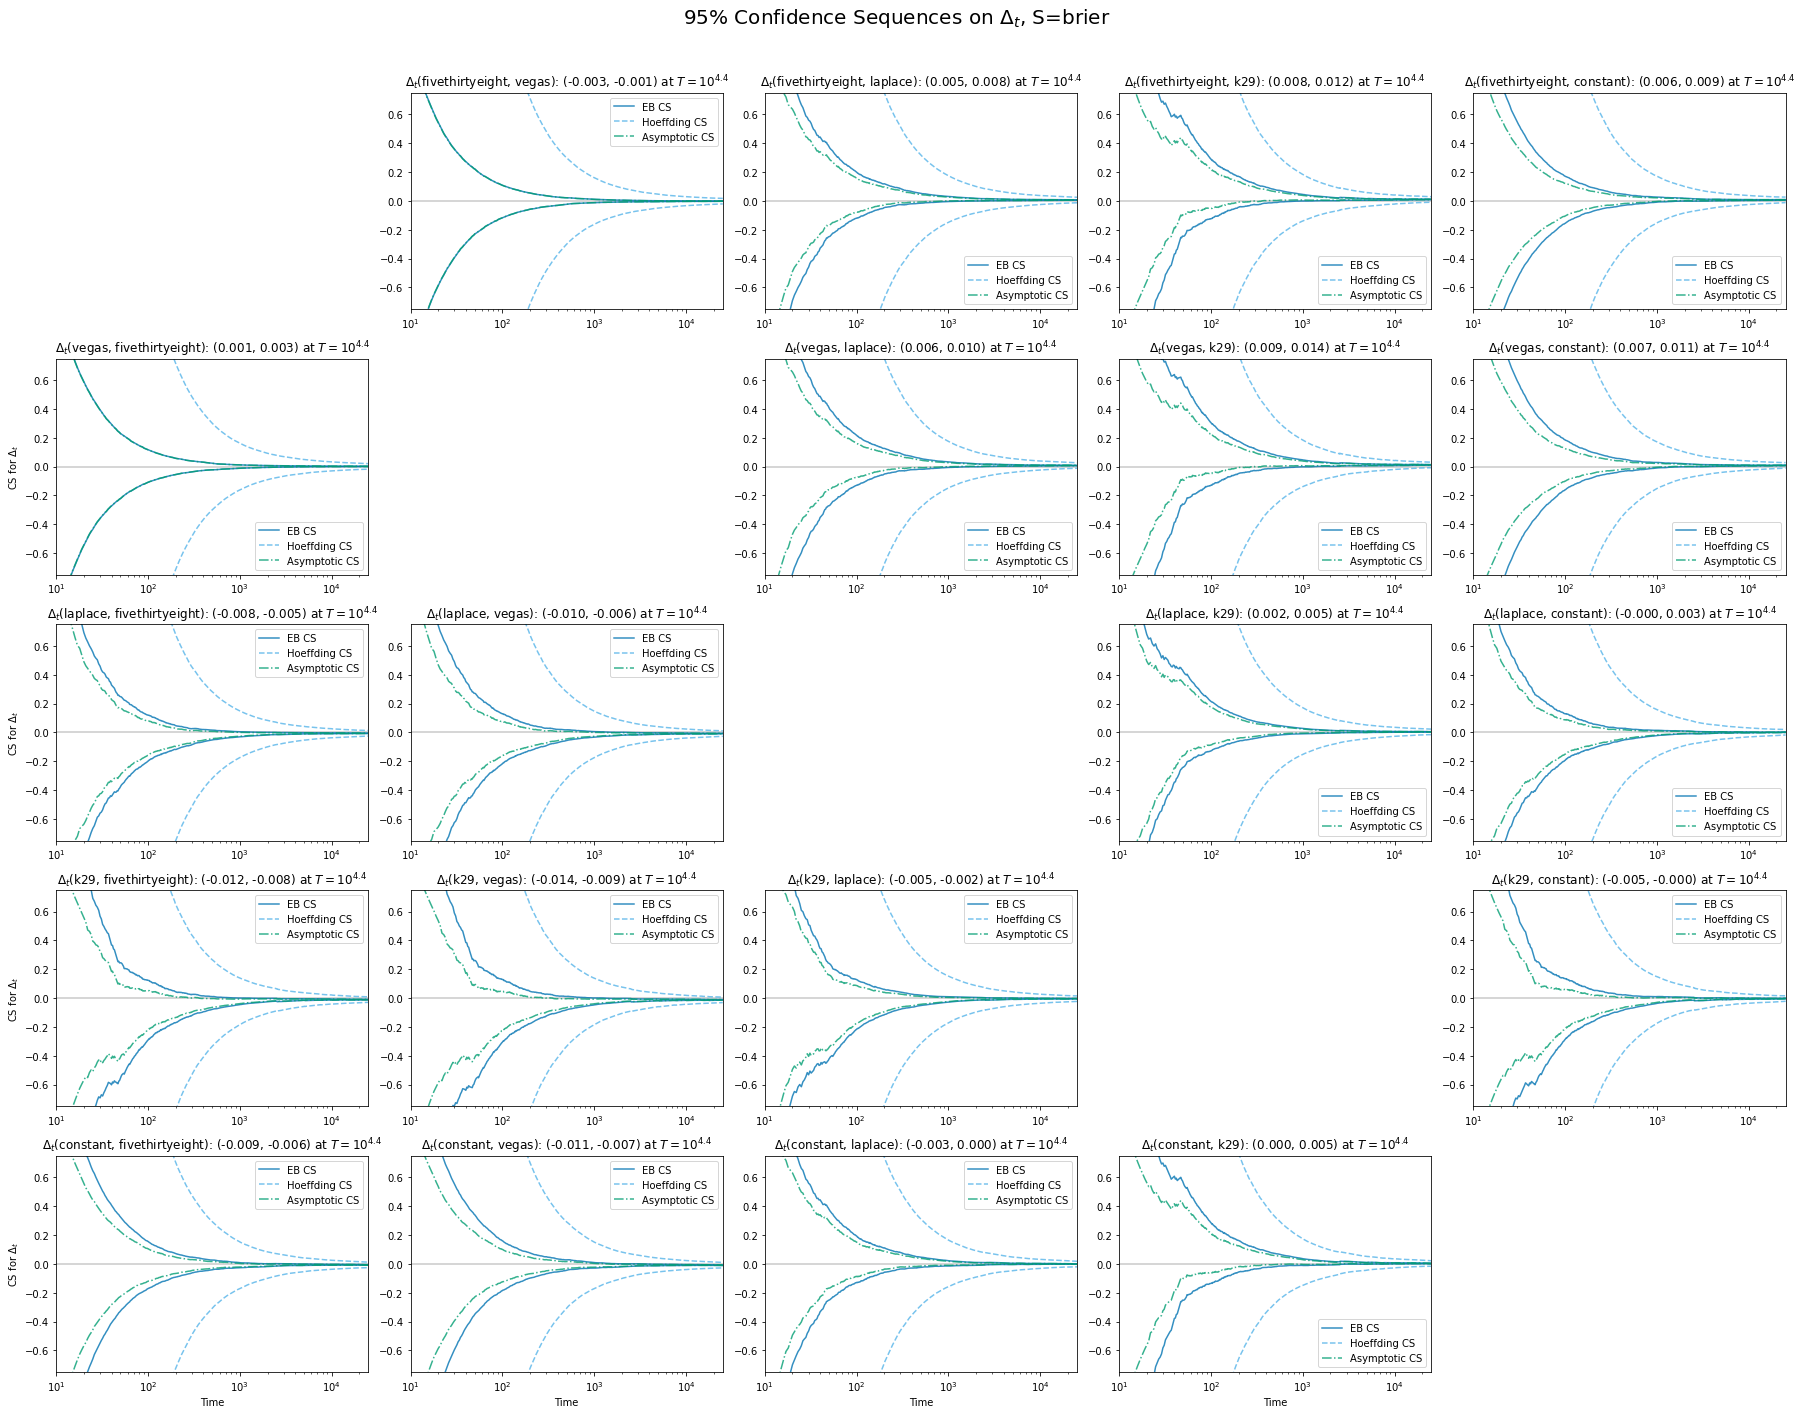

In [15]:
scoring_rule = "brier"
lo, hi = -1, 1
# scoring_rule = "logarithmic"
# lo, hi = np.log(0.01), -np.log(0.01)
ax = cc.plot_pairwise_comparisons(
    data, 
    forecasters, 
    scoring_rule=scoring_rule,
    alpha=ALPHA,
    lo=lo,
    hi=hi,
    v_opt=V_OPT,
    plots_dir=plots_dir,
    compare_baselines=("h", "acs"),
    use_logx=True,
)

### Comparison Against Laplace, i.e., the Rolling Season Average

In [16]:
def compare_against_baseline(data, forecasters, baseline, scoring_rule, save_csv=True, **kwargs):
    compdata = data[["date", "time", "data"] + forecasters].copy()
    for forecaster in forecasters:
        if forecaster == baseline:
            continue
        lcbs, ucbs = cc.compare_forecasts(
            data, 
            forecaster, 
            baseline, 
            scoring_rule=scoring_rule,
            **kwargs
        )
        compdata[f"{forecaster}_lcb"] = lcbs
        compdata[f"{forecaster}_ucb"] = ucbs
    if save_csv:
        compdata.to_csv(
            f"plots/{team}_{start_year}_{end_year}/{scoring_rule}_against_{baseline}.csv"
        )
    return compdata

In [17]:
compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline="laplace", 
    scoring_rule="brier",
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)
compdata.tail(7)

,date,time,data,fivethirtyeight,vegas,laplace,k29,constant,fivethirtyeight_lcb,fivethirtyeight_ucb,vegas_lcb,vegas_ucb,k29_lcb,k29_ucb,constant_lcb,constant_ucb
25158,2019-10-22,24384,0,0.620572,0.651163,0.528860,0.500000,0.5,0.004589,0.007931,0.006005,0.009776,-0.005224,-0.001977,-0.002938,0.000427
25159,2019-10-23,24385,0,0.590066,0.622704,0.526425,0.499644,0.5,0.004586,0.007928,0.006000,0.009771,-0.005222,-0.001976,-0.002937,0.000428
25160,2019-10-25,24386,0,0.526852,0.409836,0.475988,0.508571,0.5,0.004584,0.007926,0.006002,0.009773,-0.005223,-0.001977,-0.002937,0.000427
25161,2019-10-26,24387,0,0.586974,0.506972,0.473813,0.516476,0.5,0.004579,0.007921,0.006001,0.009771,-0.005225,-0.001978,-0.002938,0.000426
25162,2019-10-27,24388,0,0.373102,0.337323,0.471658,0.507236,0.5,0.004582,0.007924,0.006005,0.009775,-0.005226,-0.001980,-0.002939,0.000425
25163,2019-10-29,24389,0,0.594638,0.626462,0.530477,0.501092,0.5,0.004579,0.007921,0.006000,0.009770,-0.005225,-0.001978,-0.002938,0.000426
25164,2019-10-30,24390,0,0.515172,0.569340,0.528089,0.508798,0.5,0.004579,0.007921,0.005998,0.009768,-0.005224,-0.001978,-0.002937,0.000427


$\LaTeX$

In [18]:
# Brier against laplace (Table 4a)
scoring_rule = "brier"
baseline = "laplace"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        print(f"{forecaster:15s} & ({lcb:8.5f}, {ucb:8.5f}) \\\\")

fivethirtyeight & ( 0.00458,  0.00792) \\
vegas           & ( 0.00600,  0.00977) \\
k29             & (-0.00522, -0.00198) \\
constant        & (-0.00294,  0.00043) \\


In [19]:
# Winkler against laplace (Table 4b)
scoring_rule = "winkler"
baseline = "laplace"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        print(f"{forecaster:15s} & ({lcb:8.5f}, {ucb:8.5f}) \\\\")

fivethirtyeight & ( 0.04927,  0.09669) \\
vegas           & ( 0.05208,  0.09973) \\
k29             & (-0.09697, -0.04107) \\
constant        & (-0.06718, -0.02380) \\


In [20]:
# WSN forecasts for WS (Table 1)
for forecaster in forecasters:
    print(f"{forecaster:15s}", " & ".join(
        [(f"{100*p:.1f}\%" if i in [2, 3, 4] else f"{100*(1-p):.1f}\%")
         for i, p in enumerate(compdata[forecaster].tail(7).values)]
    ))

fivethirtyeight 37.9\% & 41.0\% & 52.7\% & 58.7\% & 37.3\% & 40.5\% & 48.5\%
vegas           34.9\% & 37.7\% & 41.0\% & 50.7\% & 33.7\% & 37.4\% & 43.1\%
laplace         47.1\% & 47.4\% & 47.6\% & 47.4\% & 47.2\% & 47.0\% & 47.2\%
k29             50.0\% & 50.0\% & 50.9\% & 51.6\% & 50.7\% & 49.9\% & 49.1\%
constant        50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\% & 50.0\%
